# LSTM & Redes Neuronales
En esta sección se realizara buscara darle una solucion al problema por medio de un combinacion de una Long Short Term Memory (LSTM) y una Red Neuronal

In [91]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Cargo los datasets

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# OJO: acá asumo que X_dev_full / X_test_full ya vienen escalados
# por alguna función tipo normalizar_columnas en otra celda.
X_dev_full = pd.read_csv('../data/split/X_dev_full.csv', index_col=0)
X_test_full = pd.read_csv('../data/split/X_test_full.csv', index_col=0)
y_dev = pd.read_csv('../data/split/y_dev.csv', index_col=0)
y_test = pd.read_csv('../data/split/y_test.csv', index_col=0)

# Targets que querés predecir
target_cols = [
    "altura_max_m",
    "ganancia_altura_m",
    "duracion_min",
    "distancia_km",
    "velocidad_promedio_kmh",
    "num_termicas",
    "intensidad_termicas_mean_ms",
    "tiempo_en_termicas_min",
    "tasa_ascenso_mean_ms",
]


Usando device: cuda


In [93]:
# -------------------------
# 2) DEFINIR SECUENCIALES Y ESTÁTICAS
# -------------------------

cols = X_dev_full.columns.tolist()

# Horas 09h .. 18h
hours = [f"{h:02d}h" for h in range(9, 19)]  # ['09h', ..., '18h']

# Columnas secuenciales: terminan en _09h, _10h, ..., _18h
seq_cols = [c for c in cols if any(c.endswith(f"_{h}") for h in hours)]

# Prefijos de clima (solar_rad, temp_2m, etc.)
prefixes = sorted({c.rsplit("_", 1)[0] for c in seq_cols})

# Grupos por timestep: para cada hora, las mismas variables en el mismo orden
seq_col_groups = [
    [f"{p}_{h}" for p in prefixes]
    for h in hours
]

# Columnas estáticas = todo lo que NO es secuencial
static_cols = [c for c in cols if c not in seq_cols]

print("Variables secuenciales por timestep:", prefixes)
print("Horas:", hours)
print("N seq features por timestep:", len(prefixes))
print("N static features:", len(static_cols))

Variables secuenciales por timestep: ['boundary_layer_height', 'cape', 'cloud_cover', 'precipitation', 'pressure', 'skin_temp', 'solar_rad', 'temp_2m', 'wind_speed', 'wind_u', 'wind_v']
Horas: ['09h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h']
N seq features por timestep: 11
N static features: 15


In [94]:
# -------------------------
# 3) DATASET PARA LSTM
# -------------------------

class FlightLSTMDataset(Dataset):
    def __init__(self, X_df, y_df, seq_col_groups, static_cols, target_cols):
        self.X = X_df.reset_index(drop=True)
        self.y_df = y_df.reset_index(drop=True)
        self.seq_col_groups = seq_col_groups
        self.static_cols = static_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.X)

    def _row_to_seq(self, row):
        """
        Construye matriz (T, F) para la LSTM.
        T = nº timesteps (len(hours))
        F = nº features secuenciales (len(prefixes))
        """
        seq_list = []
        for group in self.seq_col_groups:
            vals = row[group].astype("float32").tolist()   # list[float]
            seq_list.append(vals)

        seq = torch.tensor(seq_list, dtype=torch.float32)  # (T, F)
        return seq

    def __getitem__(self, idx):
        row = self.X.iloc[idx]

        # Secuencia (T, F)
        seq = self._row_to_seq(row)

        # Features estáticas (S,)
        static_vals = row[self.static_cols].astype("float32").tolist()
        static = torch.tensor(static_vals, dtype=torch.float32)

        # Targets (n_targets,)
        y_vals = self.y_df.iloc[idx][self.target_cols].astype("float32").tolist()
        y = torch.tensor(y_vals, dtype=torch.float32)

        return seq, static, y

In [95]:
# -------------------------
# 4) MODELO LSTM + MLP
# -------------------------

class ClimateLSTMRegressor(nn.Module):
    def __init__(
        self,
        seq_input_dim: int,
        static_dim: int,
        n_targets: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        bidirectional: bool = True,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=seq_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)

        self.mlp = nn.Sequential(
            nn.Linear(lstm_out_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_targets),
        )

    def forward(self, seq, static):
        # seq: (batch, T, F), static: (batch, S)
        _, (h_n, _) = self.lstm(seq)  # h_n: (num_layers*num_dirs, batch, hidden_dim)

        if self.bidirectional:
            h_forward = h_n[-2]   # (batch, hidden_dim)
            h_backward = h_n[-1]  # (batch, hidden_dim)
            h_last = torch.cat([h_forward, h_backward], dim=1)  # (batch, 2*hidden_dim)
        else:
            h_last = h_n[-1]  # (batch, hidden_dim)

        x = torch.cat([h_last, static], dim=1)  # (batch, lstm_out_dim + static_dim)
        out = self.mlp(x)  # (batch, n_targets)
        return out

In [96]:
# -------------------------
# 5) FUNCIÓN run_epoch (MSE y R² por target)
#     - Optimiza en escala ESCALADA
#     - Reporta métricas en escala ORIGINAL si scaler_y no es None
# -------------------------

def run_epoch(model, loader, optimizer=None, device=device, scaler_y=None):  # <<<
    """
    Si optimizer no es None -> modo train.
    Devuelve:
      - mse_mean: MSE promedio sobre todos los targets (escala original si scaler_y)
      - r2_mean : R² promedio sobre todos los targets (escala original si scaler_y)
      - mse_targets_list: lista de MSE por target
      - r2_targets_list : lista de R² por target
    """
    train = optimizer is not None
    model.train() if train else model.eval()

    criterion = nn.MSELoss()

    total_loss = 0.0
    all_y = []
    all_pred = []

    for seq, static, y in loader:
        seq = seq.to(device)
        static = static.to(device)
        y = y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            pred = model(seq, static)
            loss = criterion(pred, y)  # pérdida en ESCALA ESCALADA

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

        total_loss += loss.item() * y.size(0)
        all_y.append(y.detach().cpu())
        all_pred.append(pred.detach().cpu())

    total_loss /= len(loader.dataset)

    # Concatenamos todo (N, n_targets) - todavía en escala ESCALADA
    all_y = torch.cat(all_y, dim=0)
    all_pred = torch.cat(all_pred, dim=0)

    # --- Desescalar para métricas si corresponde ---
    if scaler_y is not None:
        all_y_np = all_y.numpy()
        all_pred_np = all_pred.numpy()

        # Esto es tu y_pred_orig = scaler_y.inverse_transform(y_pred_scaled), pero vectorizado
        all_y_np_orig = scaler_y.inverse_transform(all_y_np)
        all_pred_np_orig = scaler_y.inverse_transform(all_pred_np)

        all_y_t = torch.from_numpy(all_y_np_orig)
        all_pred_t = torch.from_numpy(all_pred_np_orig)
    else:
        all_y_t = all_y
        all_pred_t = all_pred

    # MSE por target (en escala ORIGINAL si scaler_y no es None)
    mse_targets = ((all_pred_t - all_y_t) ** 2).mean(dim=0)
    mse_mean = float(mse_targets.mean().item())

    # R² por target
    y_mean = all_y_t.mean(dim=0, keepdim=True)
    ss_tot = ((all_y_t - y_mean) ** 2).sum(dim=0)
    ss_res = ((all_y_t - all_pred_t) ** 2).sum(dim=0)
    r2_targets = 1.0 - ss_res / (ss_tot + 1e-8)
    r2_mean = float(r2_targets.mean().item())

    return mse_mean, r2_mean, mse_targets.tolist(), r2_targets.tolist()



FOLD 1/5


Epoch 001 | Train Loss=74064.9219, R2=-0.0542 | Val Loss=62117.0977, R2=-0.0033
Epoch 005 | Train Loss=65488.9219, R2=0.0705 | Val Loss=52264.2500, R2=0.0827
Epoch 010 | Train Loss=47428.2695, R2=0.1986 | Val Loss=41464.2227, R2=0.1631
Epoch 015 | Train Loss=39603.2852, R2=0.2770 | Val Loss=40627.6875, R2=0.1618
Epoch 020 | Train Loss=39790.2656, R2=0.3038 | Val Loss=42580.4297, R2=0.1306
Epoch 025 | Train Loss=32982.1094, R2=0.3601 | Val Loss=39665.2344, R2=0.1715
Epoch 030 | Train Loss=31815.5234, R2=0.3865 | Val Loss=41725.2148, R2=0.1286
Epoch 035 | Train Loss=29738.0234, R2=0.4256 | Val Loss=40867.5820, R2=0.1459
Epoch 040 | Train Loss=28482.3359, R2=0.4246 | Val Loss=40943.9102, R2=0.1524
Epoch 045 | Train Loss=28342.9629, R2=0.4381 | Val Loss=41177.2383, R2=0.1217
Epoch 050 | Train Loss=26190.3770, R2=0.4514 | Val Loss=46697.5156, R2=0.0747
Epoch 055 | Train Loss=25593.8457, R2=0.4665 | Val Loss=42316.1562, R2=0.1184
Epoch 060 | Train Loss=23084.4492, R2=0.4982 | Val Loss=43874.

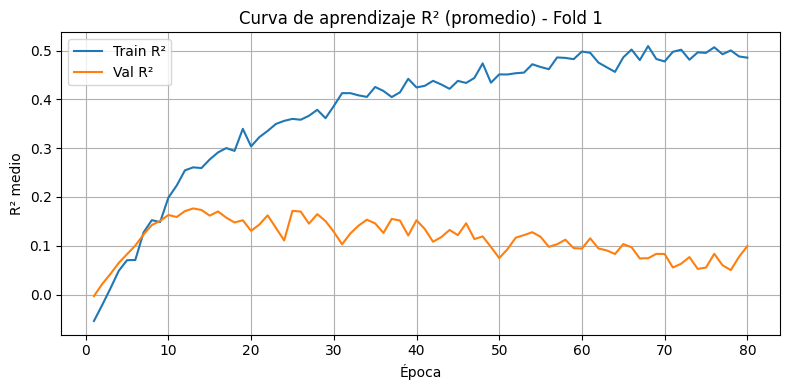

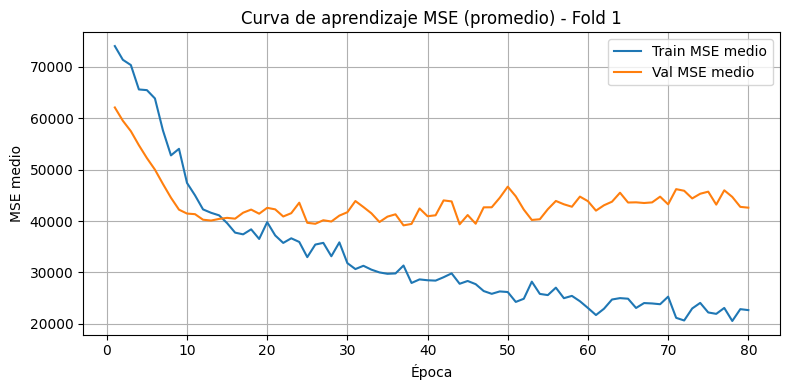

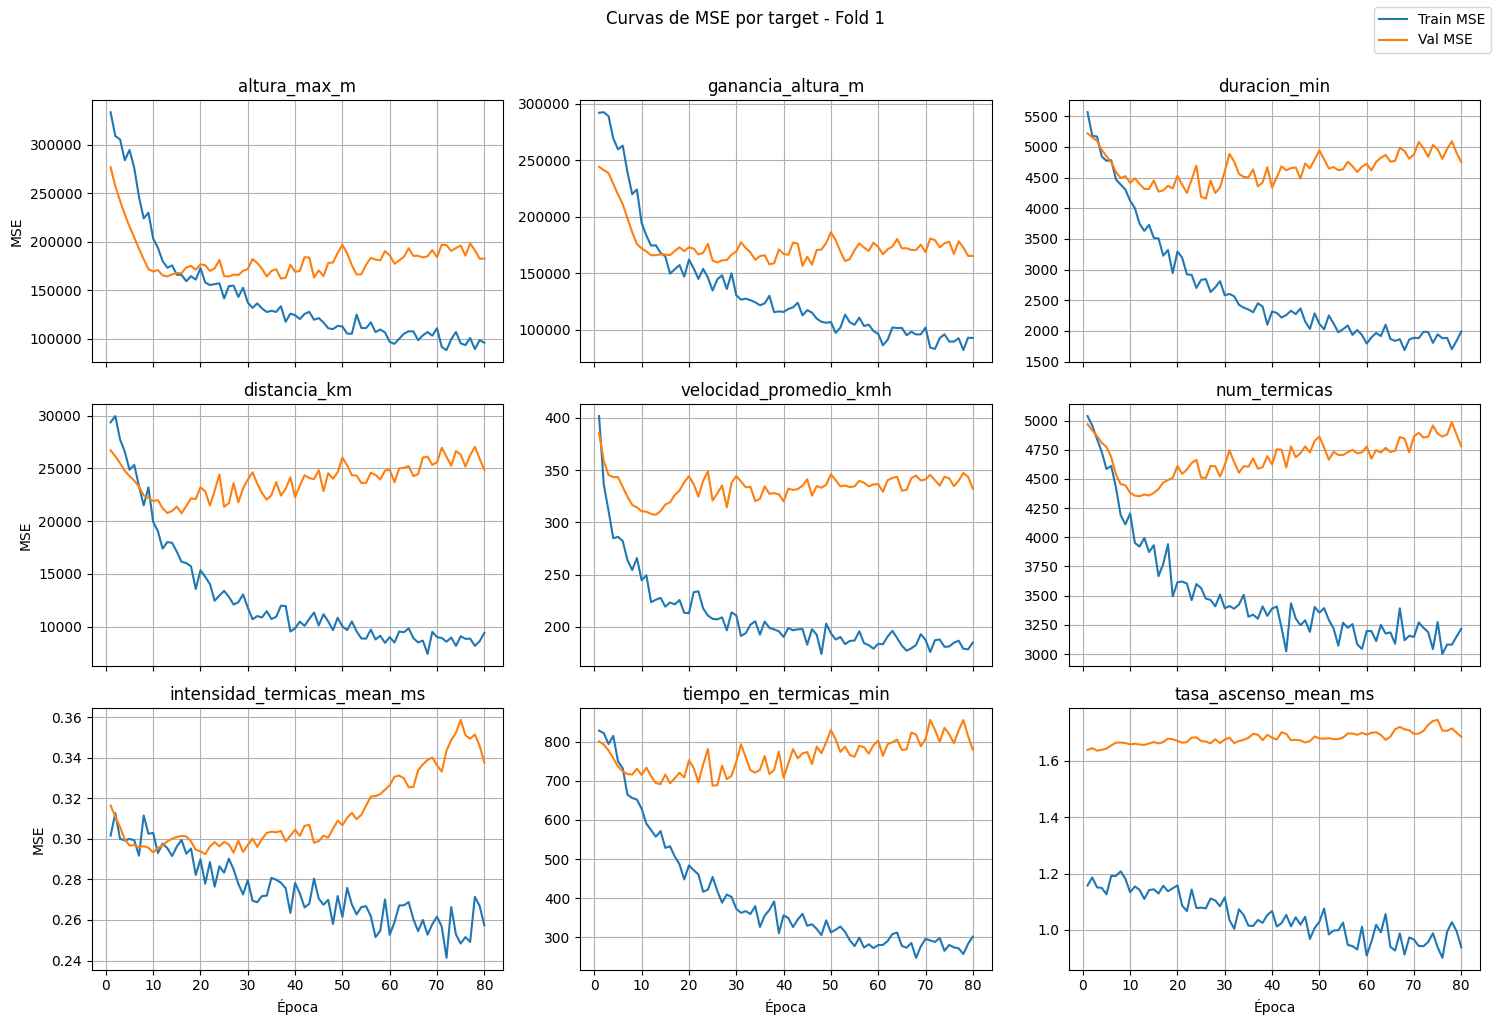

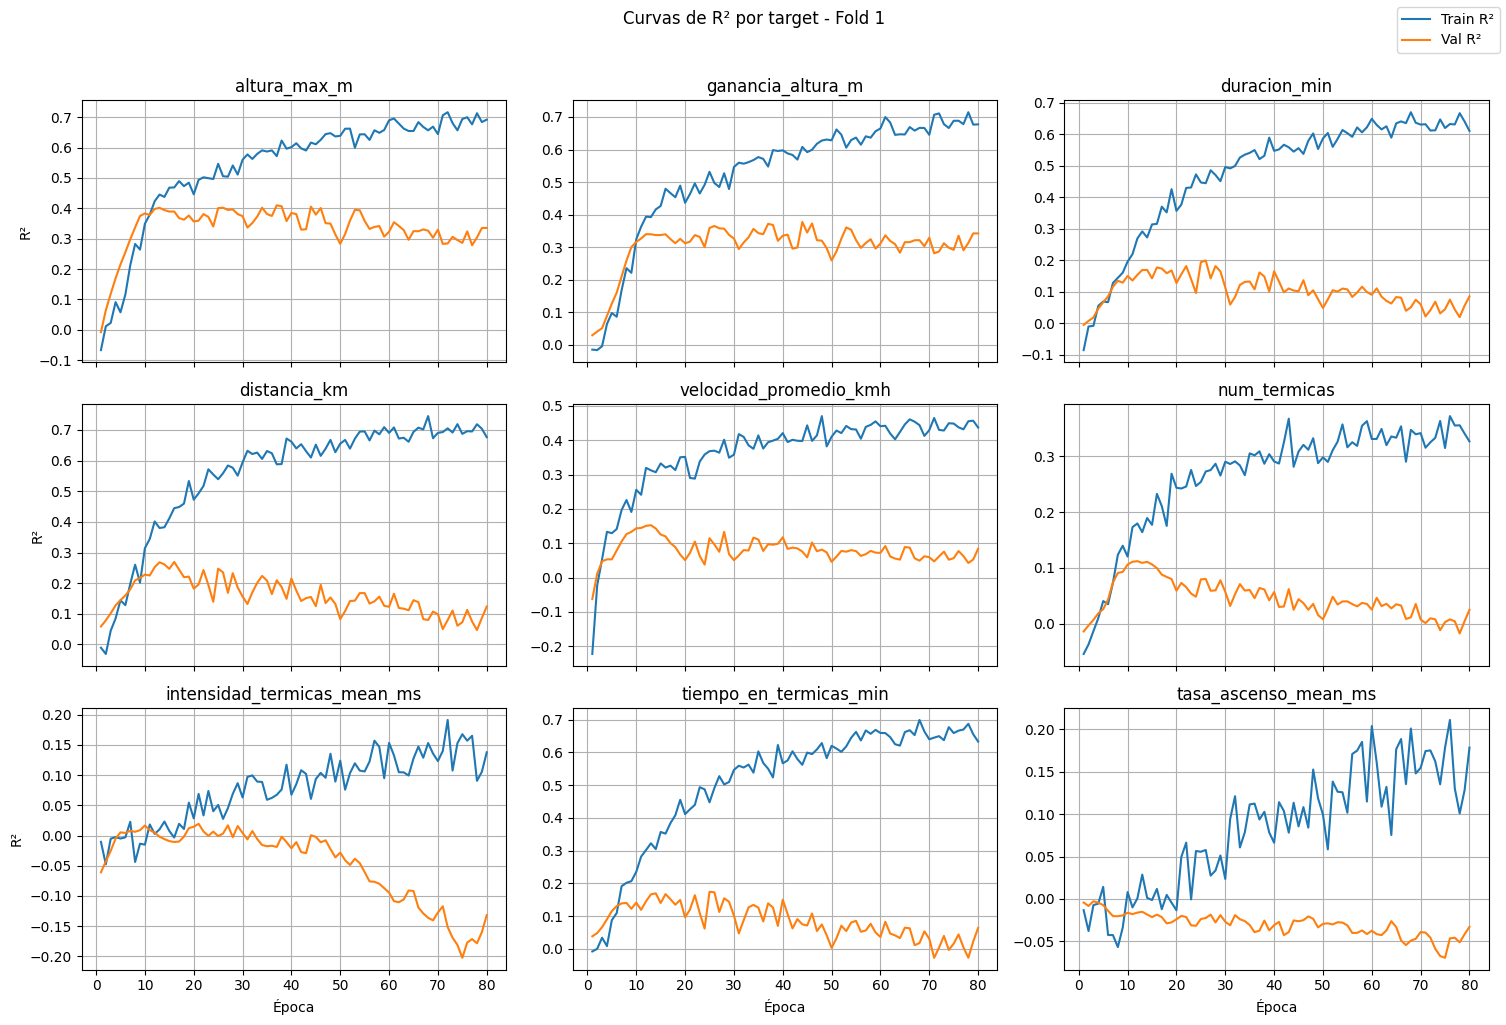


Mejor R² de validación (promedio targets): 0.1766
R² por target en este fold (escala ORIGINAL):
  altura_max_m                  : 0.4016
  ganancia_altura_m             : 0.3395
  duracion_min                  : 0.1690
  distancia_km                  : 0.2681
  velocidad_promedio_kmh        : 0.1527
  num_termicas                  : 0.1089
  intensidad_termicas_mean_ms   : -0.0019
  tiempo_en_termicas_min        : 0.1662
  tasa_ascenso_mean_ms          : -0.0151

FOLD 2/5
Epoch 001 | Train Loss=69598.3828, R2=-0.1215 | Val Loss=100477.1484, R2=-0.0277
Epoch 005 | Train Loss=60574.6523, R2=0.0240 | Val Loss=94412.5156, R2=0.0442
Epoch 010 | Train Loss=49359.2930, R2=0.1159 | Val Loss=73610.8906, R2=0.2008
Epoch 015 | Train Loss=38827.5391, R2=0.2408 | Val Loss=60682.2578, R2=0.2579
Epoch 020 | Train Loss=34671.0547, R2=0.2726 | Val Loss=58440.4844, R2=0.2798
Epoch 025 | Train Loss=32119.0391, R2=0.3149 | Val Loss=55833.9844, R2=0.2999
Epoch 030 | Train Loss=30460.8789, R2=0.3407 | Val 

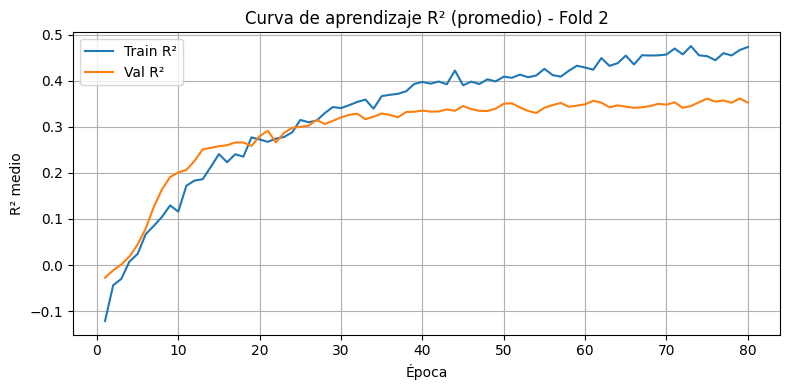

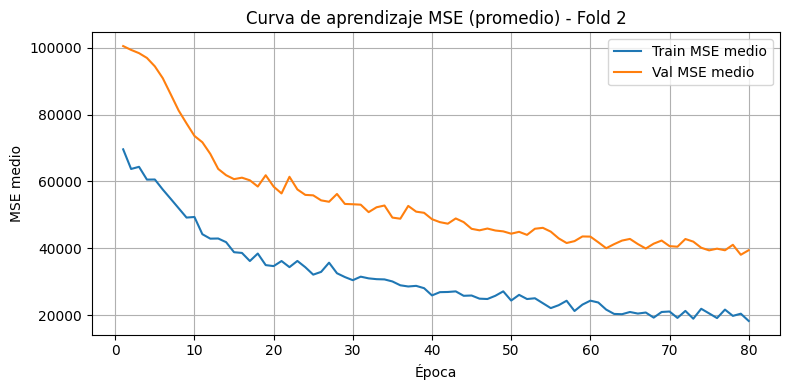

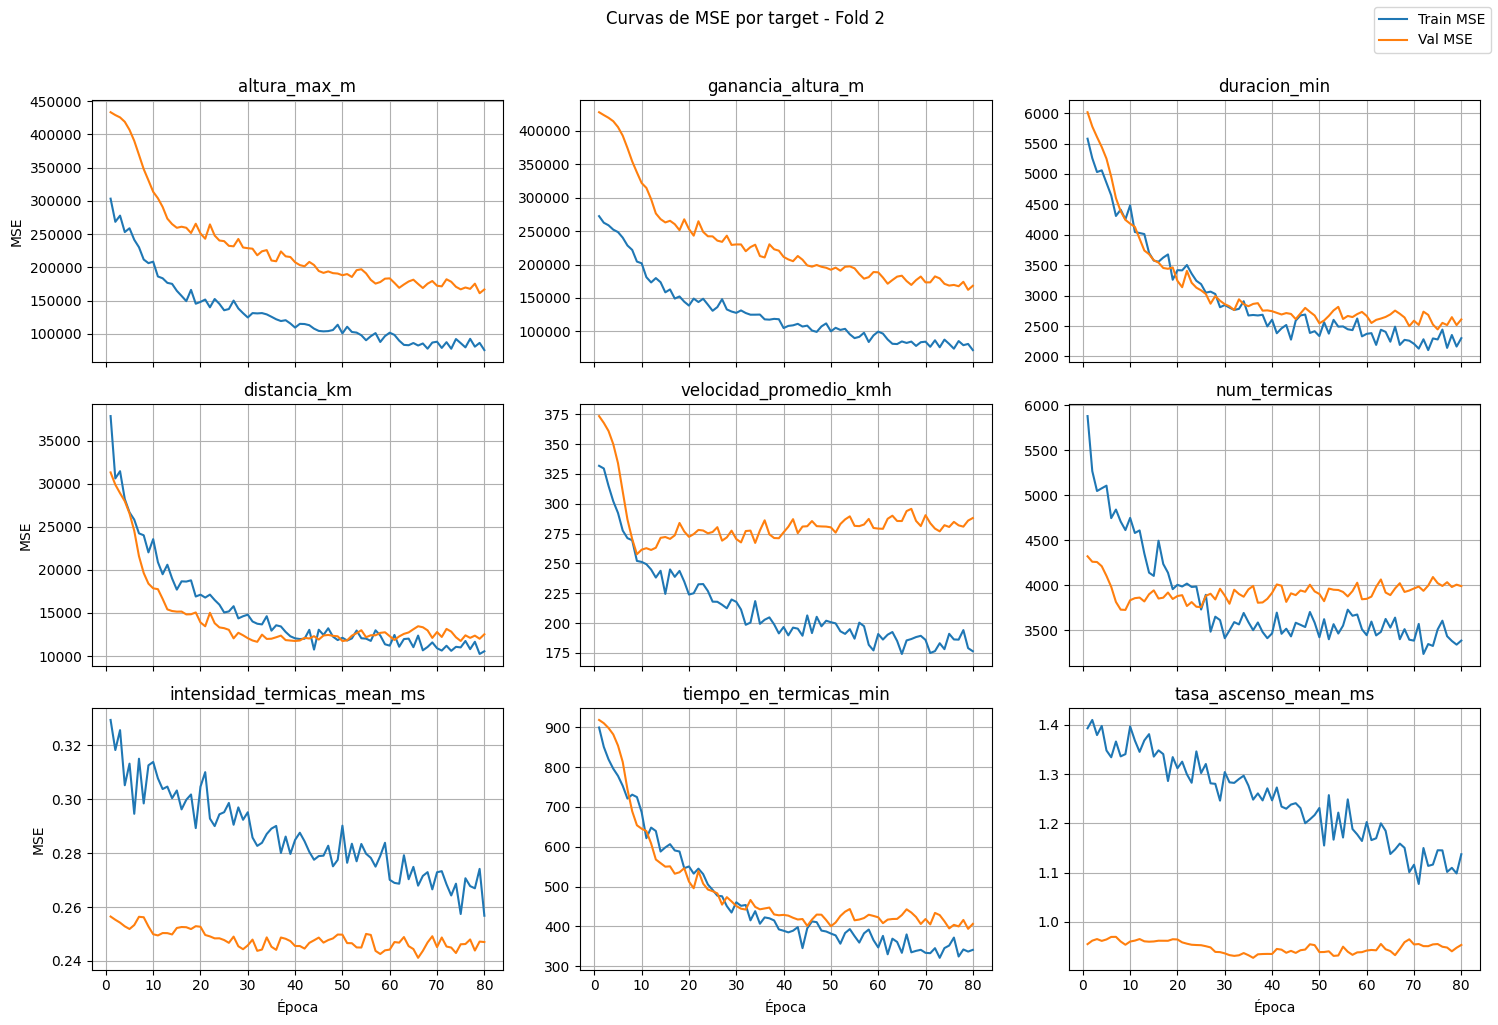

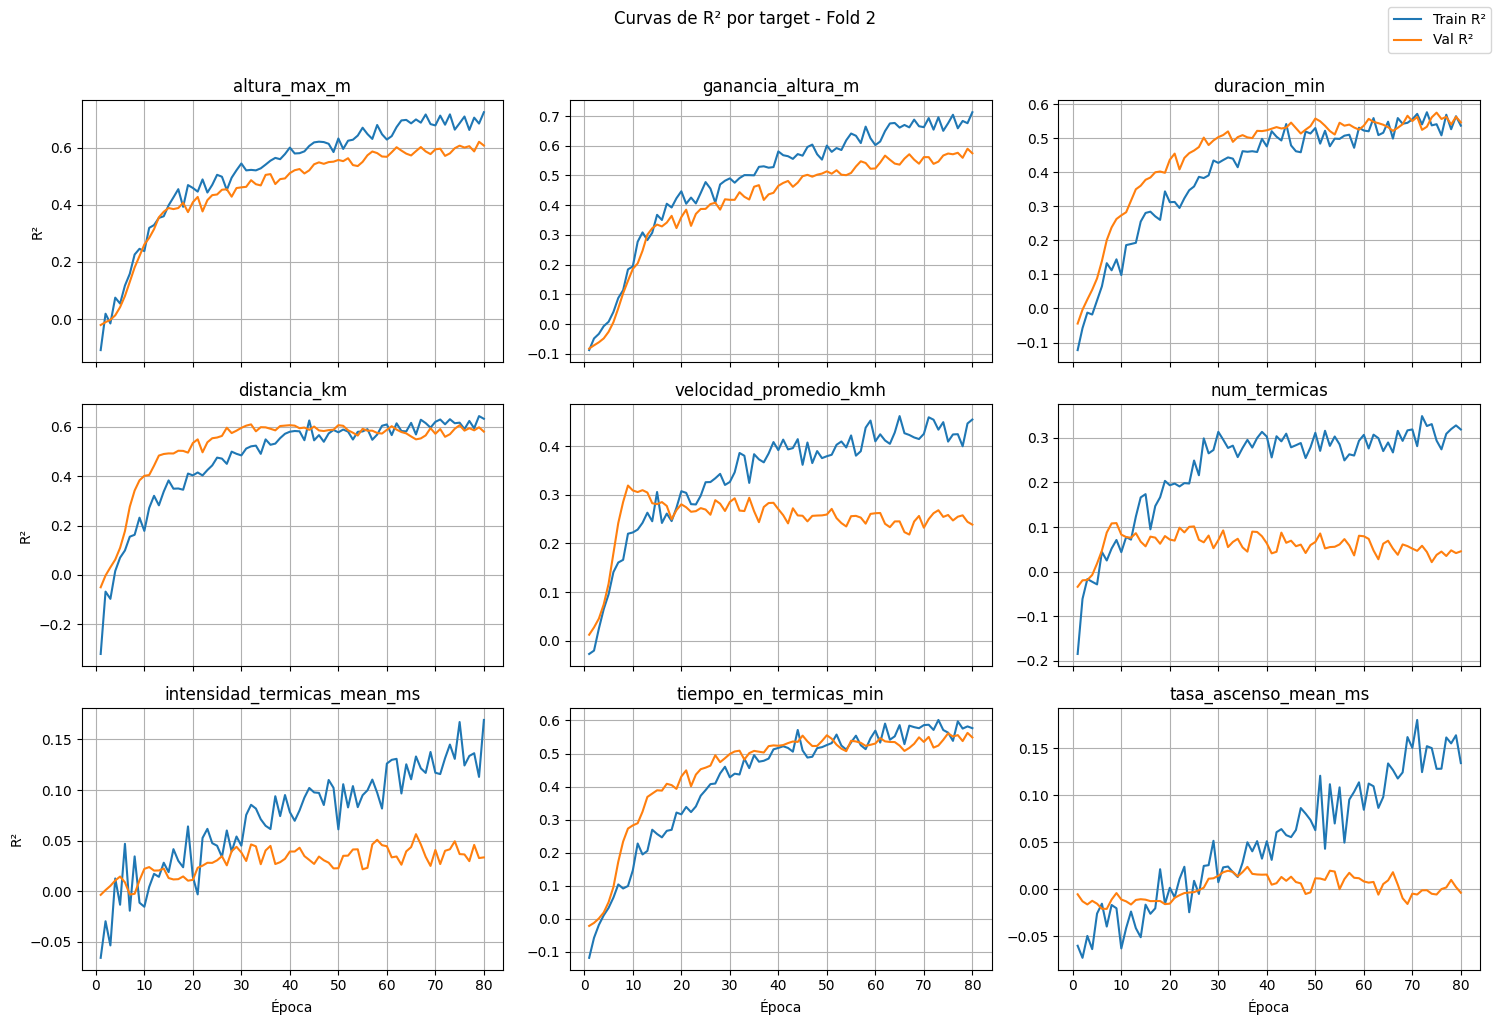


Mejor R² de validación (promedio targets): 0.3616
R² por target en este fold (escala ORIGINAL):
  altura_max_m                  : 0.6202
  ganancia_altura_m             : 0.5899
  duracion_min                  : 0.5632
  distancia_km                  : 0.5975
  velocidad_promedio_kmh        : 0.2444
  num_termicas                  : 0.0416
  intensidad_termicas_mean_ms   : 0.0328
  tiempo_en_termicas_min        : 0.5624
  tasa_ascenso_mean_ms          : 0.0024

FOLD 3/5
Epoch 001 | Train Loss=75178.4219, R2=-0.0515 | Val Loss=63459.7344, R2=-0.0259
Epoch 005 | Train Loss=69542.9062, R2=0.0389 | Val Loss=57635.2344, R2=0.0283
Epoch 010 | Train Loss=60964.5000, R2=0.1149 | Val Loss=47948.6289, R2=0.1016
Epoch 015 | Train Loss=47381.6445, R2=0.2057 | Val Loss=34130.0117, R2=0.2416
Epoch 020 | Train Loss=36640.2734, R2=0.3106 | Val Loss=23527.9609, R2=0.3430
Epoch 025 | Train Loss=35760.8555, R2=0.3516 | Val Loss=24018.9980, R2=0.3478
Epoch 030 | Train Loss=30099.2285, R2=0.3811 | Val Los

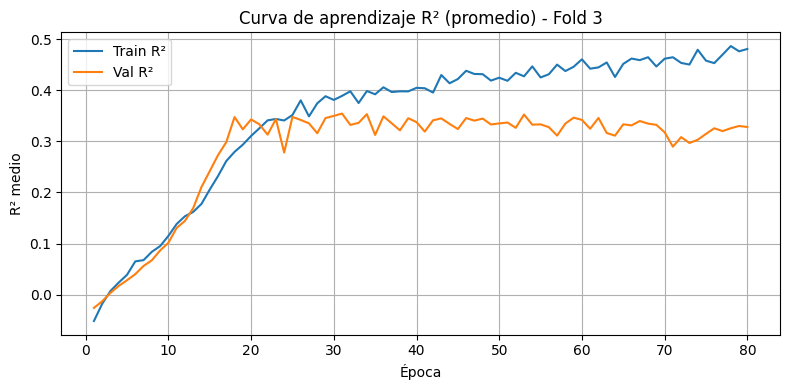

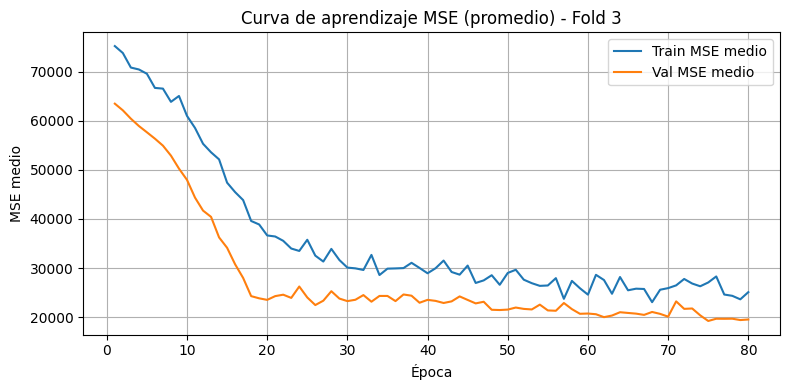

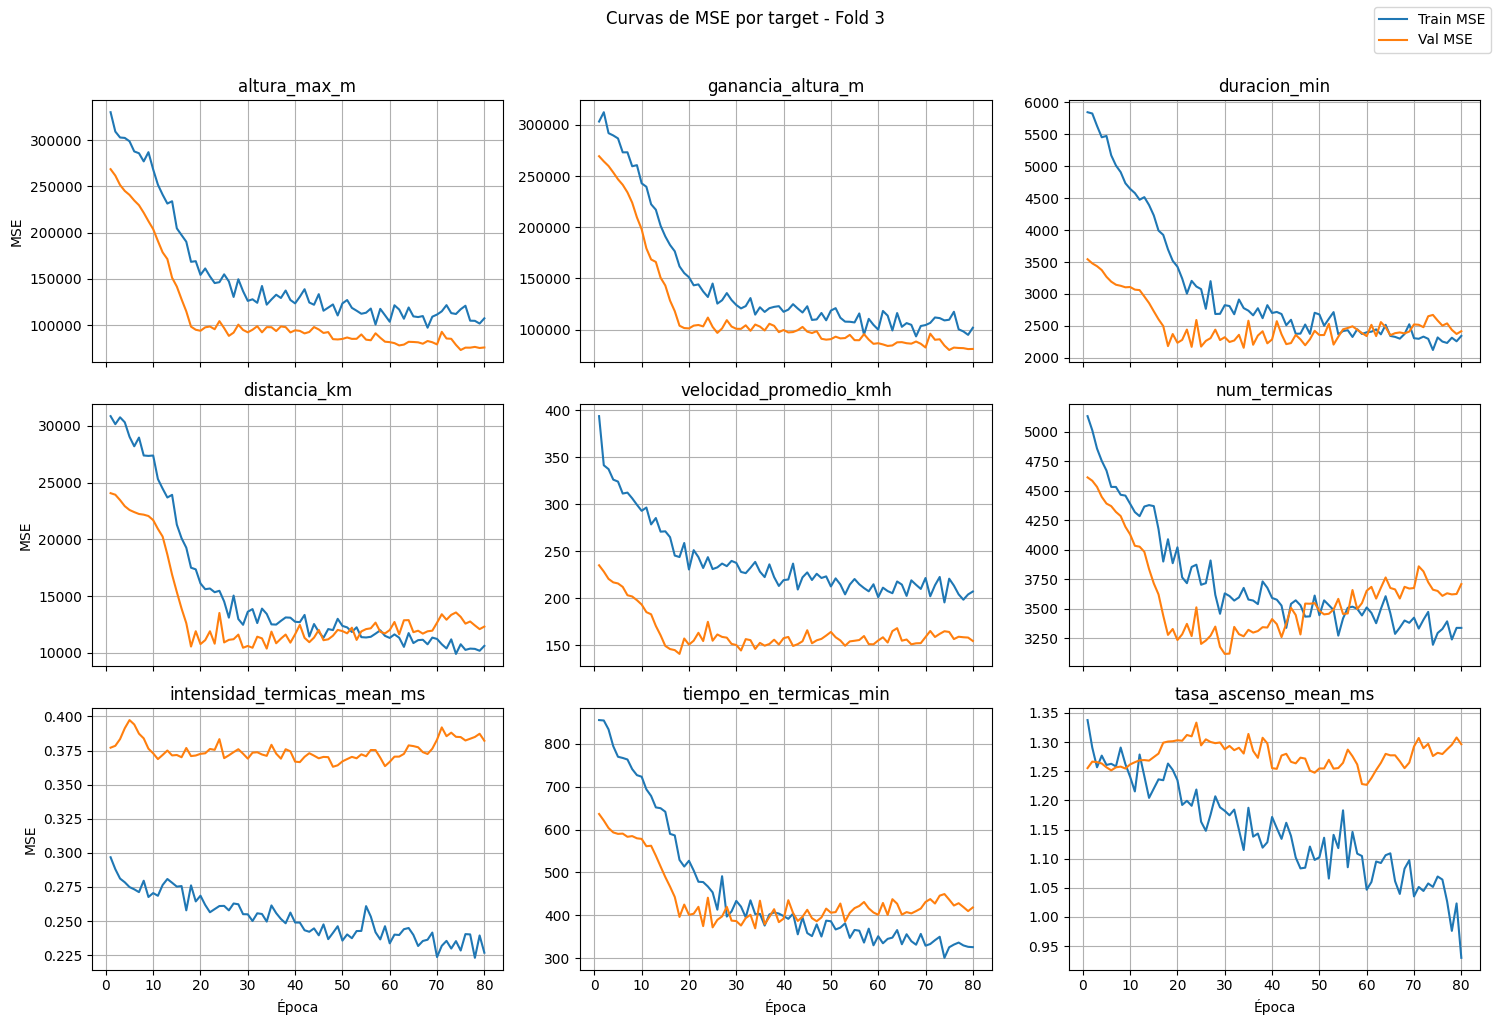

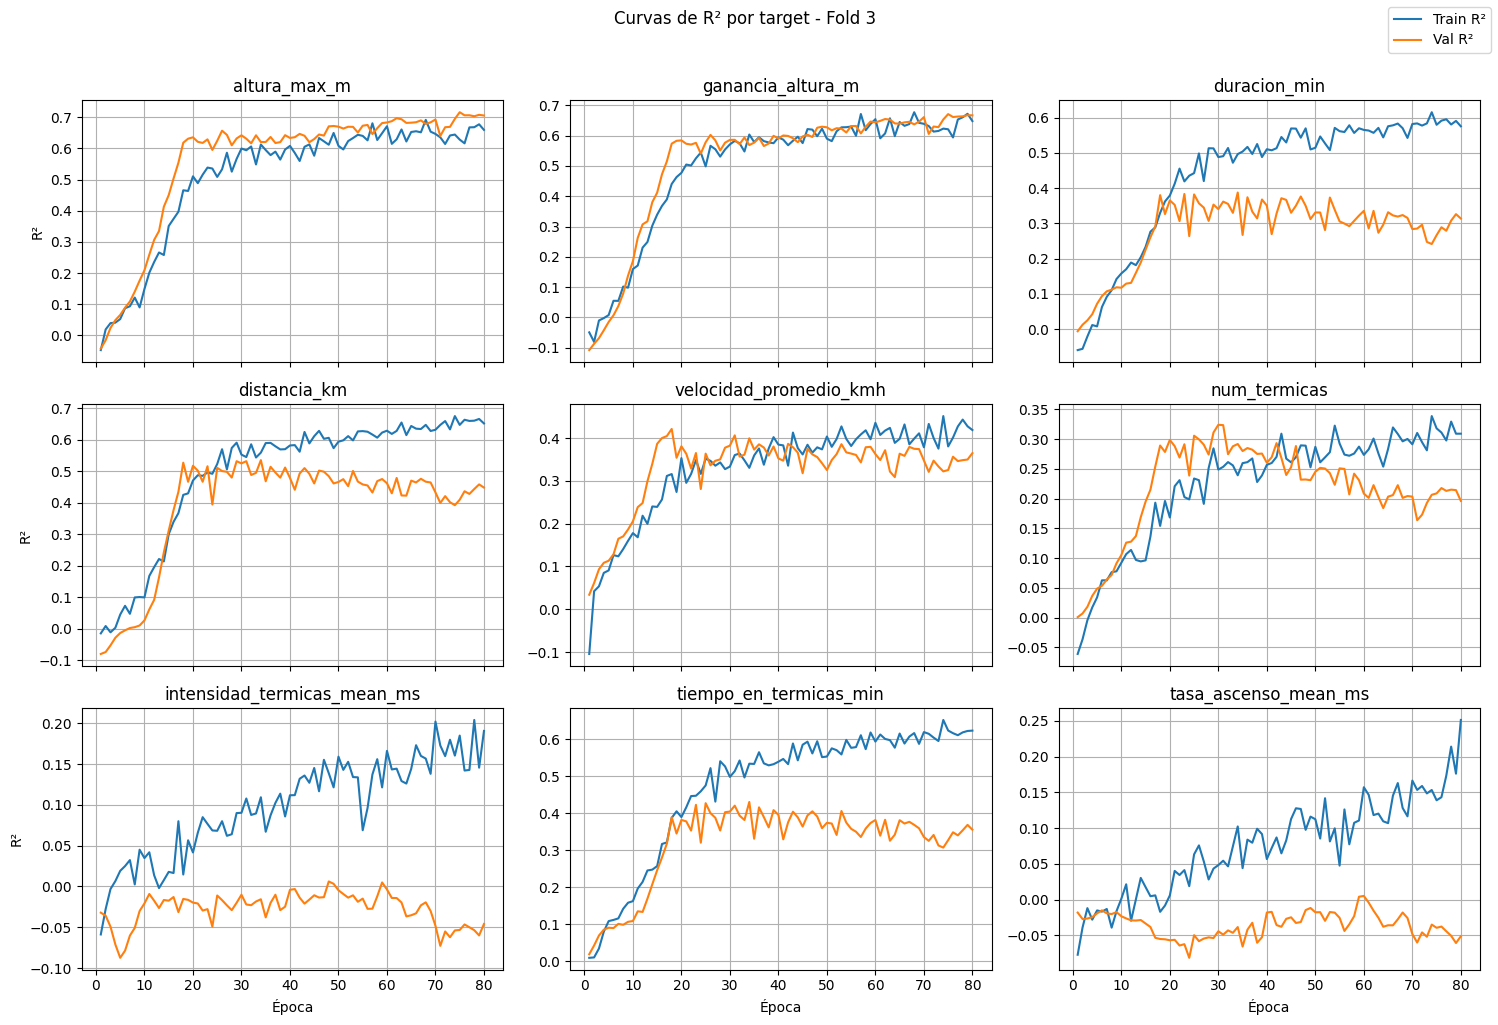


Mejor R² de validación (promedio targets): 0.3544
R² por target en este fold (escala ORIGINAL):
  altura_max_m                  : 0.6314
  ganancia_altura_m             : 0.5862
  duracion_min                  : 0.3618
  distancia_km                  : 0.5313
  velocidad_promedio_kmh        : 0.4064
  num_termicas                  : 0.3237
  intensidad_termicas_mean_ms   : -0.0221
  tiempo_en_termicas_min        : 0.4202
  tasa_ascenso_mean_ms          : -0.0491

FOLD 4/5
Epoch 001 | Train Loss=71130.7109, R2=-0.0518 | Val Loss=75327.9688, R2=-0.0120
Epoch 005 | Train Loss=61774.4844, R2=0.0565 | Val Loss=68529.9609, R2=0.0458
Epoch 010 | Train Loss=47147.7656, R2=0.1806 | Val Loss=53168.0195, R2=0.1501
Epoch 015 | Train Loss=41984.2812, R2=0.2671 | Val Loss=46913.7734, R2=0.2059
Epoch 020 | Train Loss=36493.5312, R2=0.3245 | Val Loss=45212.2344, R2=0.2180
Epoch 025 | Train Loss=32300.3984, R2=0.3692 | Val Loss=42831.7500, R2=0.2551
Epoch 030 | Train Loss=30842.3262, R2=0.3813 | Val L

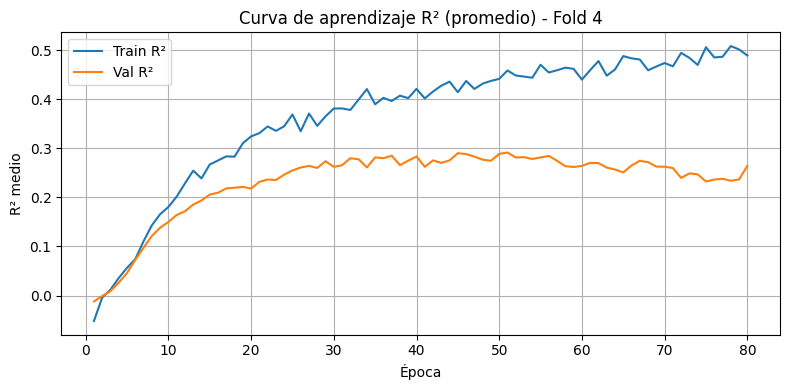

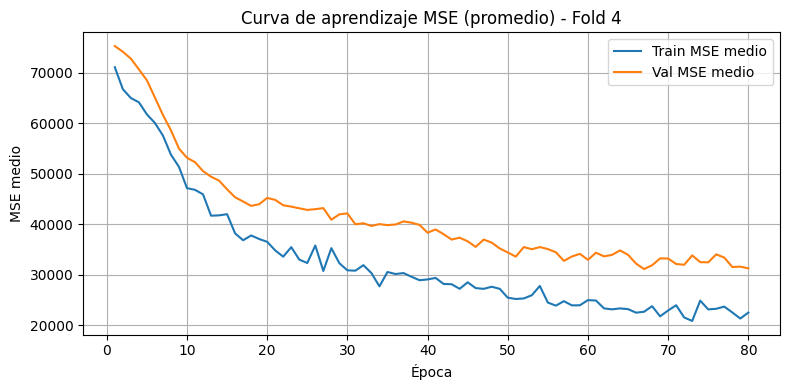

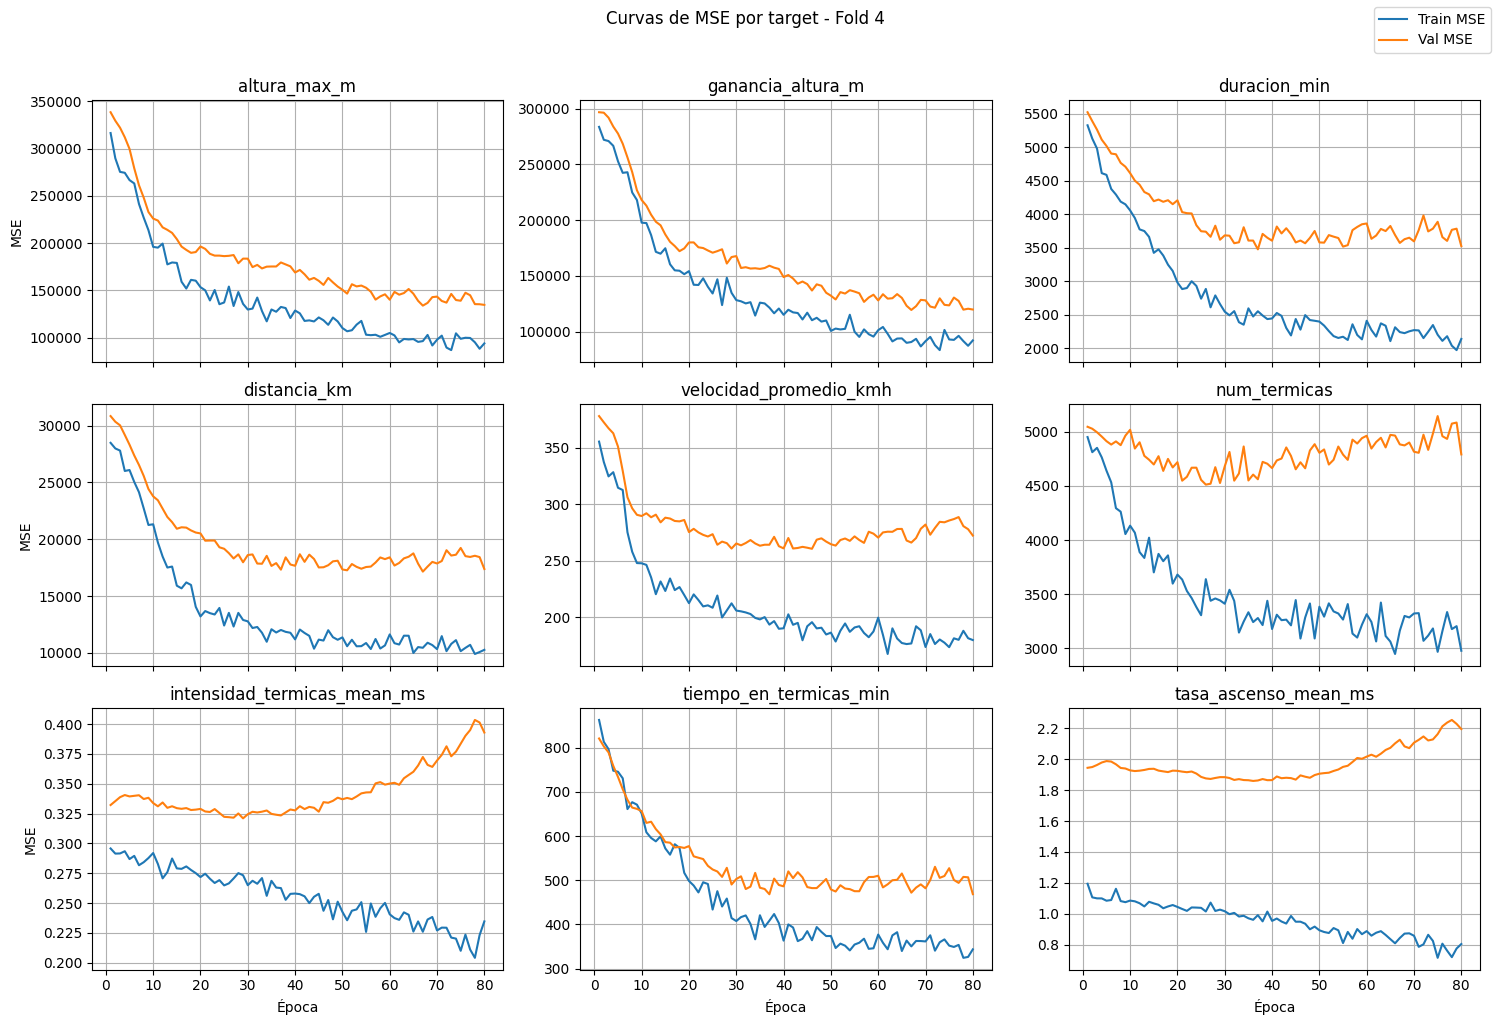

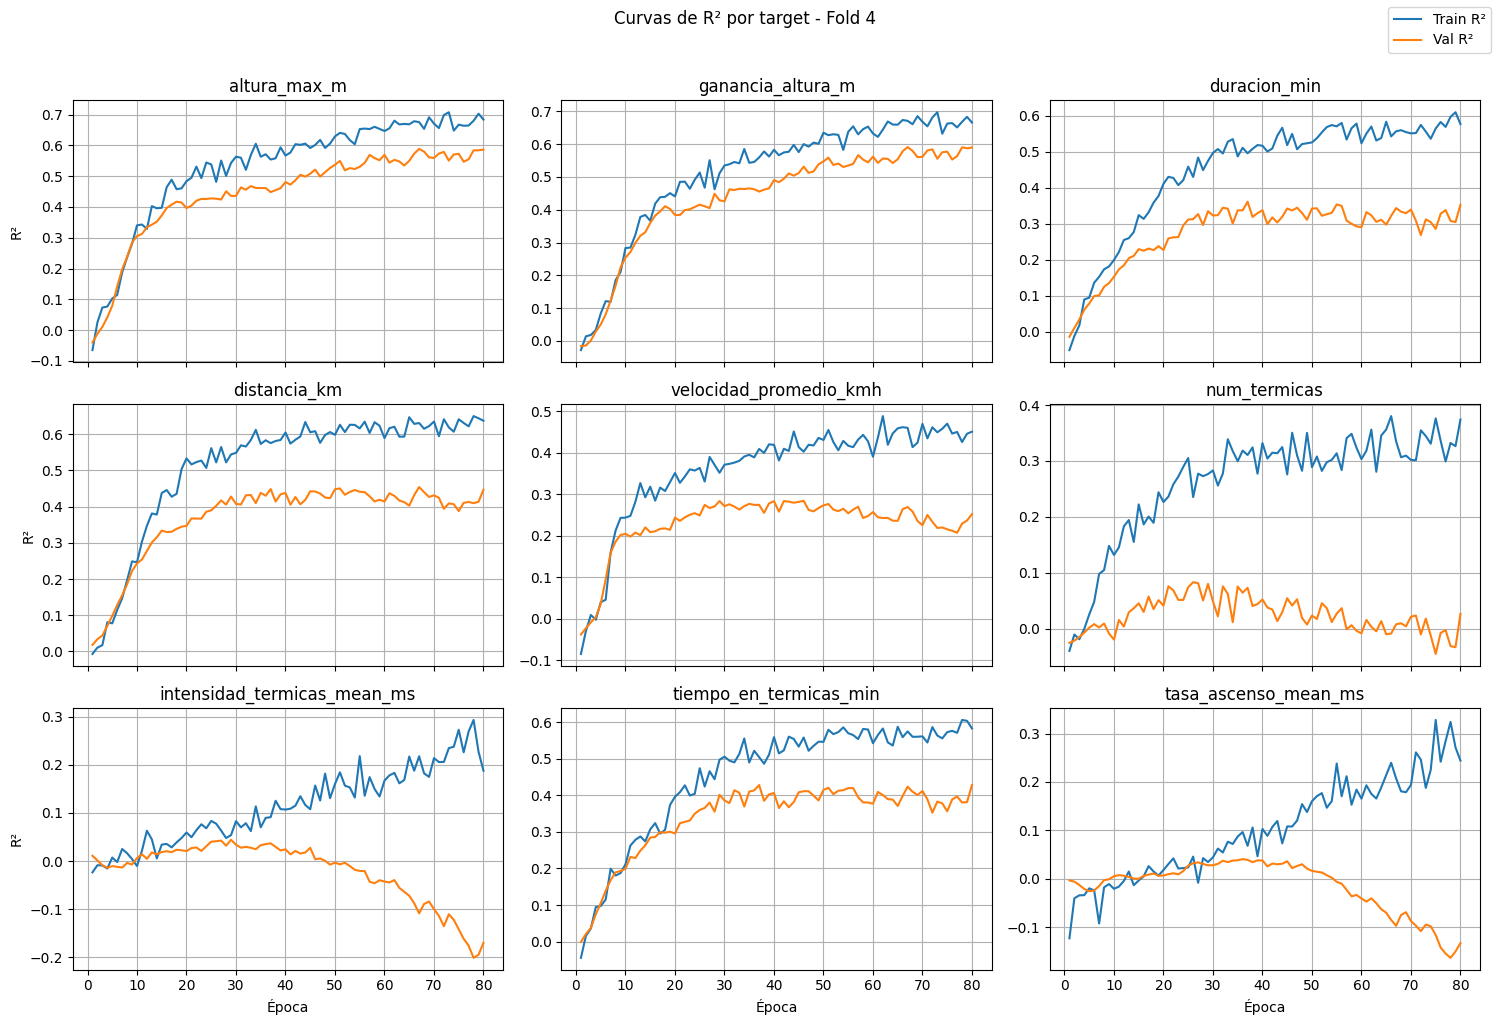


Mejor R² de validación (promedio targets): 0.2916
R² por target en este fold (escala ORIGINAL):
  altura_max_m                  : 0.5496
  ganancia_altura_m             : 0.5587
  duracion_min                  : 0.3428
  distancia_km                  : 0.4501
  velocidad_promedio_kmh        : 0.2766
  num_termicas                  : 0.0171
  intensidad_termicas_mean_ms   : -0.0067
  tiempo_en_termicas_min        : 0.4210
  tasa_ascenso_mean_ms          : 0.0148

FOLD 5/5
Epoch 001 | Train Loss=73872.4141, R2=-0.0475 | Val Loss=56270.5742, R2=-0.1599
Epoch 005 | Train Loss=67108.3438, R2=0.0485 | Val Loss=51458.9414, R2=-0.1053
Epoch 010 | Train Loss=52296.8750, R2=0.1865 | Val Loss=47462.1406, R2=0.0300
Epoch 015 | Train Loss=46429.6680, R2=0.2236 | Val Loss=45350.4258, R2=0.0580
Epoch 020 | Train Loss=42487.2930, R2=0.2590 | Val Loss=39340.2031, R2=0.1322
Epoch 025 | Train Loss=38289.3398, R2=0.3062 | Val Loss=36603.8984, R2=0.1660
Epoch 030 | Train Loss=35327.1172, R2=0.3487 | Val L

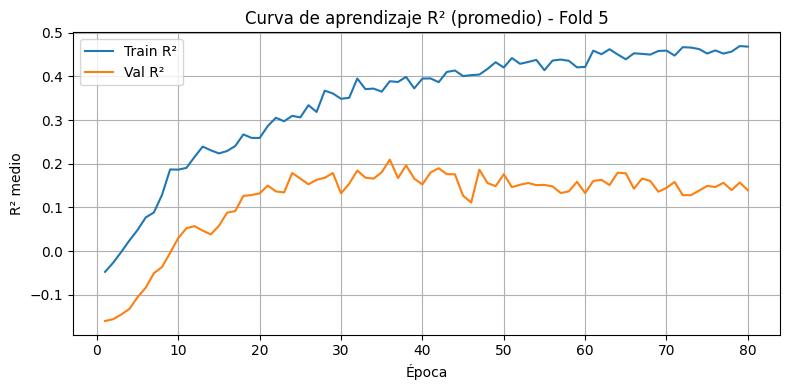

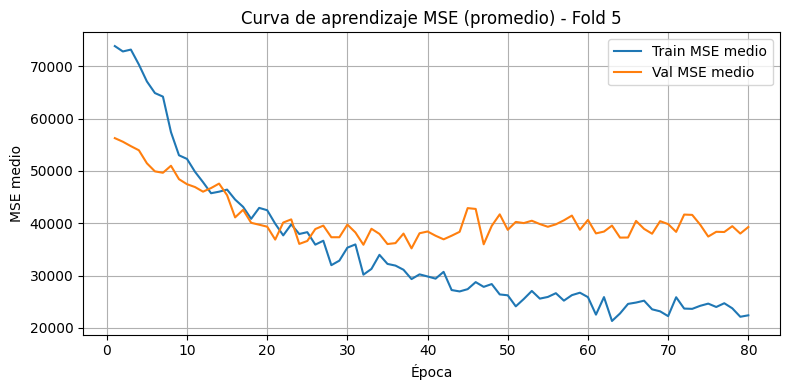

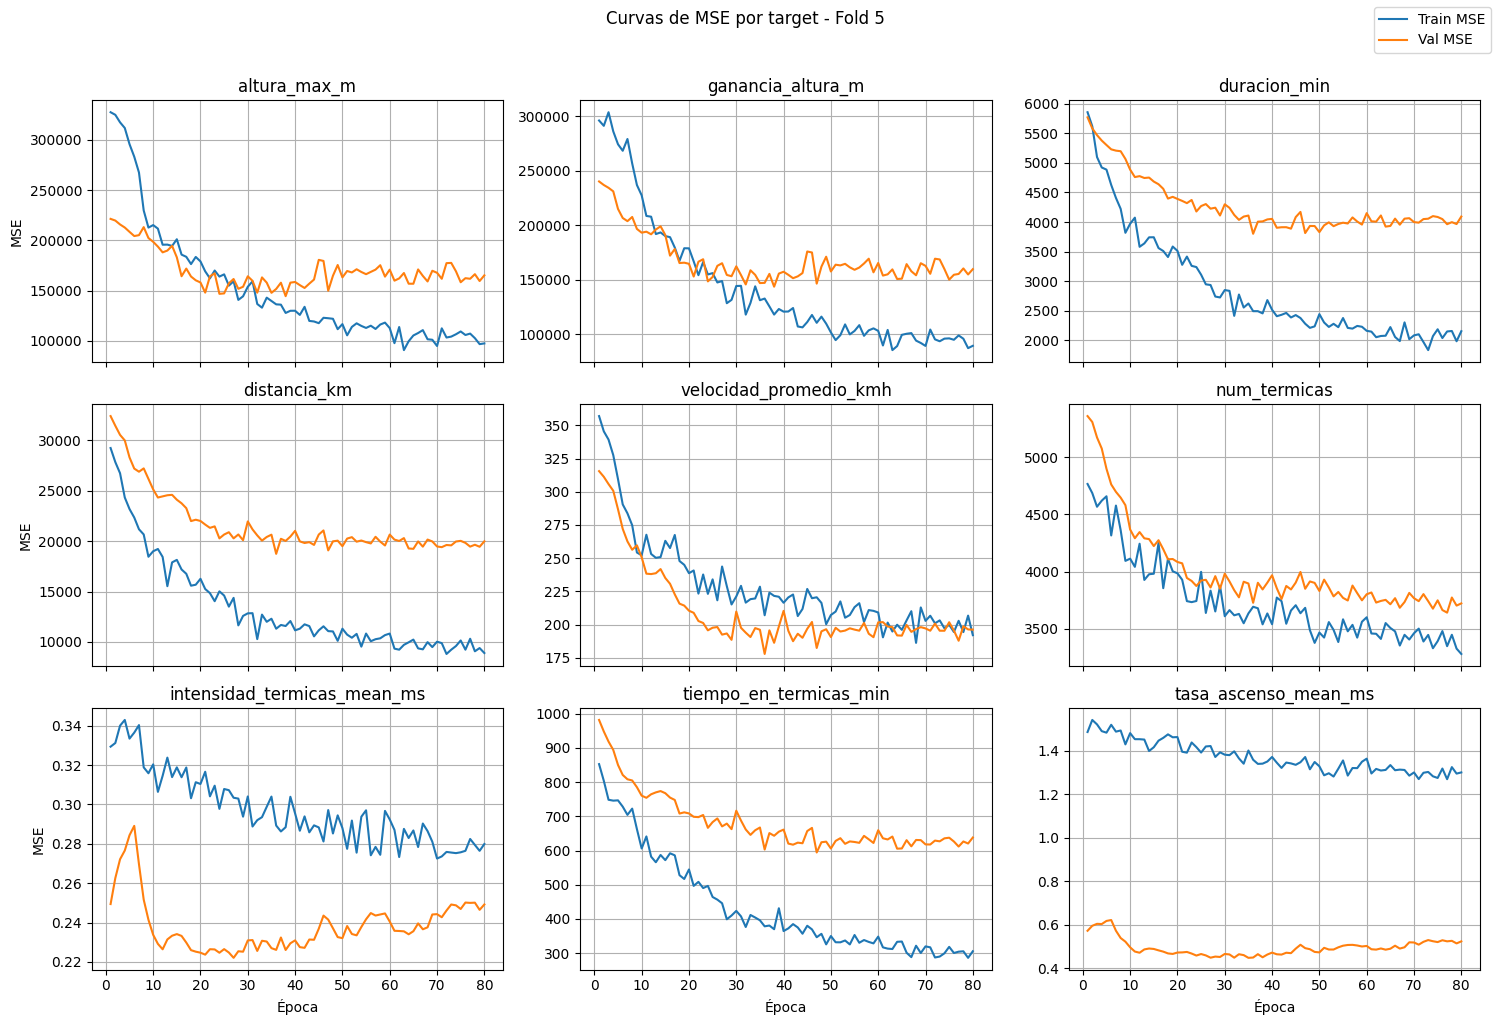

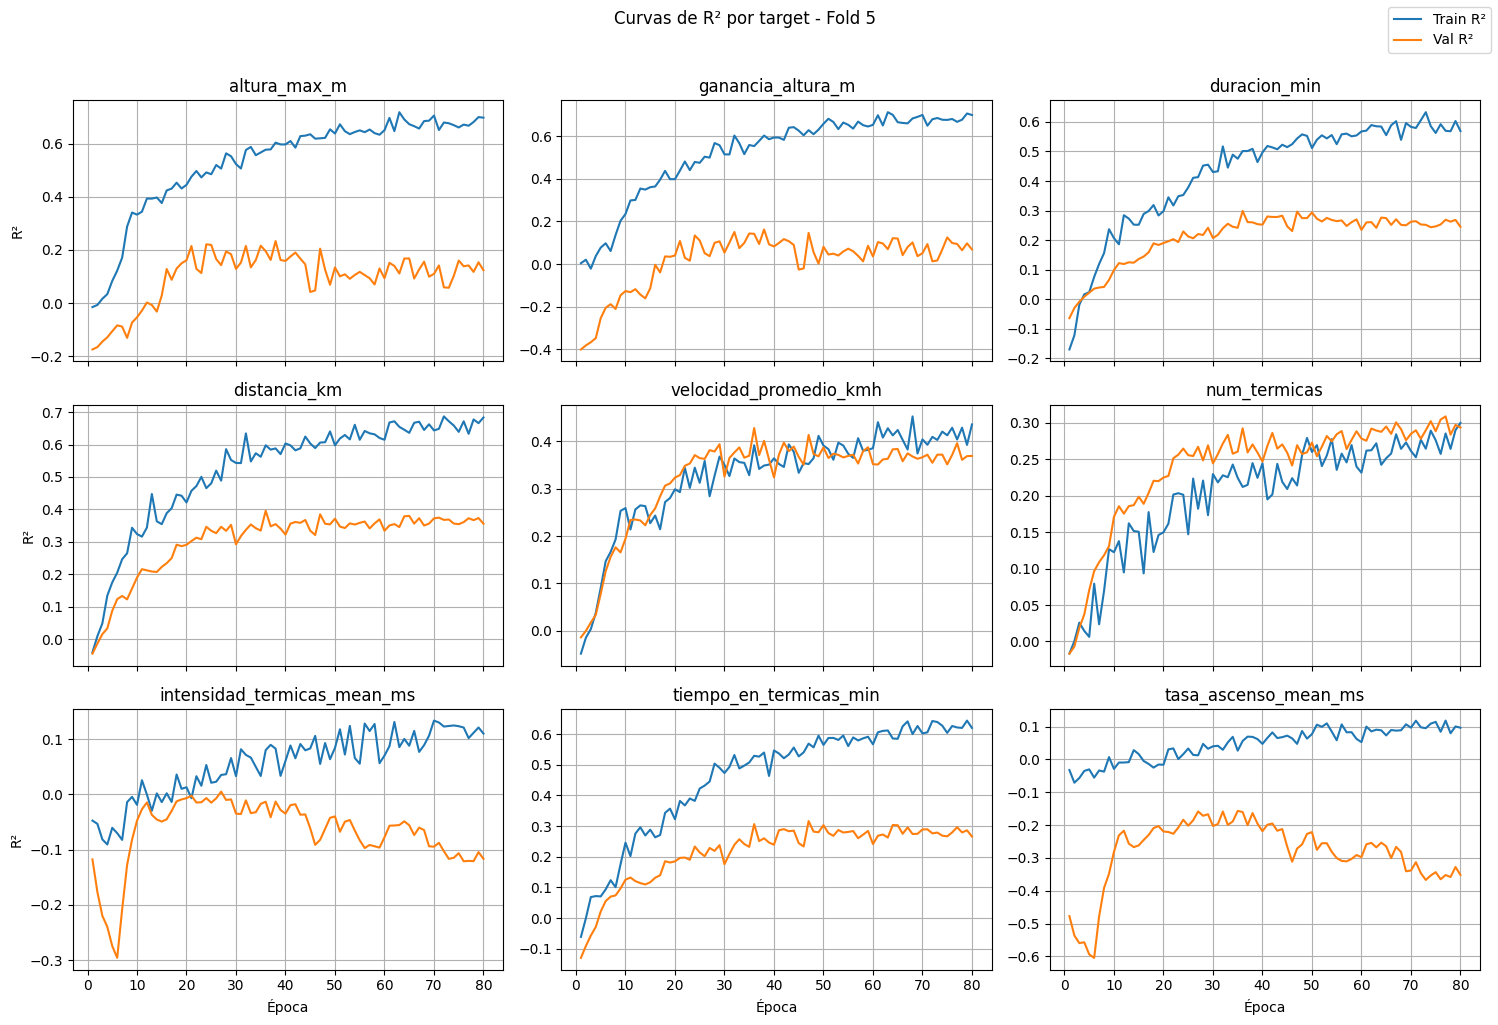


Mejor R² de validación (promedio targets): 0.2096
R² por target en este fold (escala ORIGINAL):
  altura_max_m                  : 0.1956
  ganancia_altura_m             : 0.1420
  duracion_min                  : 0.2988
  distancia_km                  : 0.3960
  velocidad_promedio_kmh        : 0.4283
  num_termicas                  : 0.2926
  intensidad_termicas_mean_ms   : -0.0134
  tiempo_en_termicas_min        : 0.3065
  tasa_ascenso_mean_ms          : -0.1603


In [ ]:
# -------------------------
# 6) CROSS-VALIDATION + CURVAS
# -------------------------

n_splits = 5
batch_size = 32
n_epochs = 80
lr = 1e-3
weight_decay = 1e-5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = []  # guardará R² por target en cada fold

seq_input_dim = len(prefixes)
static_dim = len(static_cols)
n_targets = len(target_cols)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_dev_full)):
    print(f"FOLD {fold+1}/{n_splits}")

    X_tr = X_dev_full.iloc[train_idx].reset_index(drop=True)
    y_tr = y_dev.iloc[train_idx].reset_index(drop=True)
    X_va = X_dev_full.iloc[val_idx].reset_index(drop=True)
    y_va = y_dev.iloc[val_idx].reset_index(drop=True)

    # ----- Escalar y DENTRO del fold para evitar leakage -----
    scaler_y = StandardScaler()                     # <<<
    y_tr_scaled = y_tr.copy()
    y_va_scaled = y_va.copy()

    y_tr_scaled[target_cols] = scaler_y.fit_transform(y_tr[target_cols])
    y_va_scaled[target_cols] = scaler_y.transform(y_va[target_cols])
    # ---------------------------------------------------------

    train_ds = FlightLSTMDataset(X_tr, y_tr_scaled, seq_col_groups, static_cols, target_cols)
    val_ds   = FlightLSTMDataset(X_va, y_va_scaled, seq_col_groups, static_cols, target_cols)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size*2, shuffle=False)

    # Modelo nuevo por fold
    model = ClimateLSTMRegressor(
        seq_input_dim=seq_input_dim,
        static_dim=static_dim,
        n_targets=n_targets,
        hidden_dim=64,
        num_layers=1,
        bidirectional=True,
        dropout=0.1,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_r2 = -1e9
    best_state = None

    # Historial para curvas globales
    history_train_r2 = []
    history_val_r2 = []
    history_train_loss = []
    history_val_loss = []

    # Historial por target
    history_train_loss_targets = []  # list of [MSE_t1, ..., MSE_t9]
    history_val_loss_targets = []
    history_train_r2_targets = []
    history_val_r2_targets = []

    for epoch in range(1, n_epochs + 1):
        train_loss, train_r2, train_mse_t, train_r2_t = run_epoch(
            model, train_loader, optimizer=optimizer, device=device, scaler_y=scaler_y  # <<<
        )
        val_loss, val_r2, val_mse_t, val_r2_t = run_epoch(
            model, val_loader, optimizer=None, device=device, scaler_y=scaler_y         # <<<
        )

        # Guardar historial global
        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        history_train_r2.append(train_r2)
        history_val_r2.append(val_r2)

        # Guardar historial por target
        history_train_loss_targets.append(train_mse_t)
        history_val_loss_targets.append(val_mse_t)
        history_train_r2_targets.append(train_r2_t)
        history_val_r2_targets.append(val_r2_t)

        # Guardar mejor estado según R² promedio de validación
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            checkpoint = {
                "model_state": best_state,
                "scaler_y": scaler_y,      # para desescalar después
                "target_cols": target_cols,
                "fold": fold + 1,
                "val_r2": best_val_r2,
            }
            torch.save(checkpoint, f"modelos/lstm_fold{fold+1}_best.pt")
            
        if epoch % 5 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:03d} | "
                f"Train Loss={train_loss:.4f}, R2={train_r2:.4f} | "
                f"Val Loss={val_loss:.4f}, R2={val_r2:.4f}"
            )

    # ---- Curvas de aprendizaje global (promedio sobre targets) ----
    epochs_axis = range(1, n_epochs + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(epochs_axis, history_train_r2, label="Train R²")
    plt.plot(epochs_axis, history_val_r2, label="Val R²")
    plt.xlabel("Época")
    plt.ylabel("R² medio")
    plt.title(f"Curva de aprendizaje R² (promedio) - Fold {fold+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(epochs_axis, history_train_loss, label="Train MSE medio")
    plt.plot(epochs_axis, history_val_loss, label="Val MSE medio")
    plt.xlabel("Época")
    plt.ylabel("MSE medio")
    plt.title(f"Curva de aprendizaje MSE (promedio) - Fold {fold+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- Curvas por target: MSE ----
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i, target_name in enumerate(target_cols):
        ax = axes[i]
        train_vals = [ep[i] for ep in history_train_loss_targets]
        val_vals   = [ep[i] for ep in history_val_loss_targets]

        ax.plot(epochs_axis, train_vals, label="Train MSE")
        ax.plot(epochs_axis, val_vals,   label="Val MSE")
        ax.set_title(target_name)
        ax.grid(True)

        if i % 3 == 0:
            ax.set_ylabel("MSE")
        if i // 3 == 2:
            ax.set_xlabel("Época")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"Curvas de MSE por target - Fold {fold+1}", y=1.02)
    plt.tight_layout()
    plt.show()

    # ---- Curvas por target: R² ----
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i, target_name in enumerate(target_cols):
        ax = axes[i]
        train_vals = [ep[i] for ep in history_train_r2_targets]
        val_vals   = [ep[i] for ep in history_val_r2_targets]

        ax.plot(epochs_axis, train_vals, label="Train R²")
        ax.plot(epochs_axis, val_vals,   label="Val R²")
        ax.set_title(target_name)
        ax.grid(True)

        if i % 3 == 0:
            ax.set_ylabel("R²")
        if i // 3 == 2:
            ax.set_xlabel("Época")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"Curvas de R² por target - Fold {fold+1}", y=1.02)
    plt.tight_layout()
    plt.show()

    # ---- Evaluar mejor modelo del fold en validación ----
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    _, val_r2_final, _, val_r2_targets = run_epoch(
        model, val_loader, optimizer=None, device=device, scaler_y=scaler_y  # <<<
    )

    print("\nMejor R² de validación (promedio targets):", f"{val_r2_final:.4f}")
    print("R² por target en este fold (escala ORIGINAL):")
    for name, r2v in zip(target_cols, val_r2_targets):
        print(f"  {name:30s}: {r2v:.4f}")

    fold_results.append(val_r2_targets)

In [ ]:
# -------------------------
# 7) RESUMEN FINAL CV
# -------------------------

fold_results = np.vstack(fold_results)  # (n_splits, n_targets)

print("RESUMEN CROSS-VALIDATION (LSTM+MLP)")
print("MEJOR MODELO FOLD 2")

mean_r2_targets = fold_results.mean(axis=0)
std_r2_targets = fold_results.std(axis=0)

for name, mu, sd in zip(target_cols, mean_r2_targets, std_r2_targets):
    print(f"{name:30s}: R² CV medio = {mu:.4f} ± {sd:.4f}")

print("R² CV PROMEDIO (sobre todos los targets):", f"{mean_r2_targets.mean():.4f}")



RESUMEN CROSS-VALIDATION (LSTM+MLP)
MEJOR MODELO FOLD 2
altura_max_m                  : R² CV medio = 0.4797 ± 0.1640
ganancia_altura_m             : R² CV medio = 0.4433 ± 0.1771
duracion_min                  : R² CV medio = 0.3471 ± 0.1273
distancia_km                  : R² CV medio = 0.4486 ± 0.1134
velocidad_promedio_kmh        : R² CV medio = 0.3017 ± 0.1031
num_termicas                  : R² CV medio = 0.1568 ± 0.1276
intensidad_termicas_mean_ms   : R² CV medio = -0.0023 ± 0.0188
tiempo_en_termicas_min        : R² CV medio = 0.3753 ± 0.1323
tasa_ascenso_mean_ms          : R² CV medio = -0.0414 ± 0.0632
----------------------------------------------------------------------
R² CV PROMEDIO (sobre todos los targets): 0.2787


PRUEBO EL MEJOR FOLD EN EL TEST

In [101]:
checkpoint = torch.load("modelos/lstm_fold2_best.pt", map_location=device)

# Reconstruís el modelo con la MISMA config que usaste en el CV
model = ClimateLSTMRegressor(
    seq_input_dim=seq_input_dim,
    static_dim=static_dim,
    n_targets=len(target_cols),
    hidden_dim=64,
    num_layers=1,
    bidirectional=True,
    dropout=0.1,
).to(device)

model.load_state_dict(checkpoint["model_state"])
model.eval()  # por las dudas
scaler_y = checkpoint["scaler_y"]

y_test_scaled = y_test.copy()
y_test_scaled[target_cols] = scaler_y.transform(y_test[target_cols])

test_ds = FlightLSTMDataset(
    X_test_full,          # asumimos que X_test_full ya está escalado igual que X_dev_full
    y_test_scaled,        # OJO: acá va y_test_scaled
    seq_col_groups,
    static_cols,
    target_cols,
)
test_loader = DataLoader(test_ds, batch_size=batch_size*2, shuffle=False)

test_loss, test_r2_final, _, test_r2_targets = run_epoch(
    model,                # acá va el modelo, no el state_dict
    test_loader,
    optimizer=None,
    device=device,
    scaler_y=scaler_y,    # para que desescale y compute métricas en escala original
)

print("R² promedio en TEST:", test_r2_final)
for name, r2v in zip(target_cols, test_r2_targets):
    print(f"{name:30s}: {r2v:.4f}")


/var/tmp/ipykernel_10110/1217083518.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("modelos/lstm_fold2_best.pt", map_location=device)


R² promedio en TEST: 0.4015539586544037
altura_max_m                  : 0.6594
ganancia_altura_m             : 0.6335
duracion_min                  : 0.5239
distancia_km                  : 0.6451
velocidad_promedio_kmh        : 0.4119
num_termicas                  : 0.2560
intensidad_termicas_mean_ms   : -0.0350
tiempo_en_termicas_min        : 0.5978
tasa_ascenso_mean_ms          : -0.0785
